# 23:00 UTC Artifact

Several meteorological variables in the 5-, 15-, and 30-minute datasets exhibit an artifact causing all values in each daily 23:00–23:55 block (UTC) to be identical.  This creates a stair step or notch in the time series of these variables.

Affected fields include (but may not be limited to) ambient temperature, wind speed and direction, and ambient pressure.  The three irradiance components are not affected.

In [1]:
import pvlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fetch an example 5-minute dataset and show that the values from 23:00 to 23:55 UTC are all the same:

In [2]:
df_5min, _ = pvlib.iotools.get_psm3(latitude=40, longitude=-100,
                                    names='2020', interval=5,
                                    api_key='DEMO_KEY', email='assessingsolar@gmail.com',
                                    map_variables=True, leap_day=True)

In [3]:
columns = ['temp_air', 'wind_speed', 'wind_direction', 'pressure']
df_5min[columns].tz_convert('UTC').loc['2020-06-01 22:45':'2020-06-02 00:15']

,temp_air,wind_speed,wind_direction,pressure
2020-06-01 22:45:00+00:00,33.9,5.5,174.0,930.0
2020-06-01 22:50:00+00:00,33.8,5.5,174.0,930.0
2020-06-01 22:55:00+00:00,33.6,5.4,173.0,930.0
2020-06-01 23:00:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:05:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:10:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:15:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:20:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:25:00+00:00,33.5,5.4,172.0,930.0
2020-06-01 23:30:00+00:00,33.5,5.4,172.0,930.0


Note that the repeated value is different for each day; it seems like the value for 23:00 is legitimate but copied into the subsequent eleven timestamps.  This is a little plainer when plotting several days:

Text(0.5, 0, 'Local Standard Time')

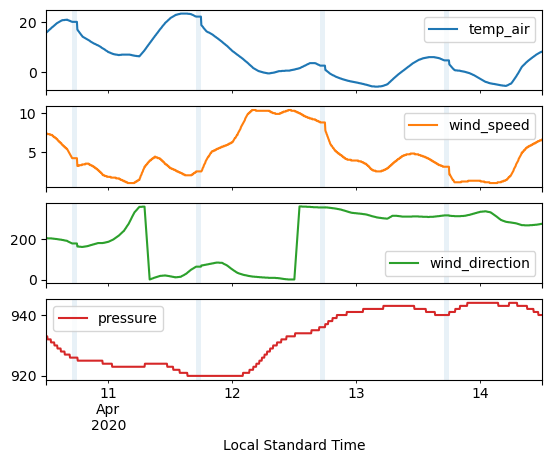

In [4]:
subset = df_5min.loc['2020-04-10 12:00':'2020-04-14 12:00']
axes = subset[columns].plot(subplots=True)

# highlight the 23:00 UTC hour each day
offset = df_5min.index[0].utcoffset()
for dt in np.unique(subset.index.floor('d')):
    st = dt + pd.Timedelta(hours=23) + offset
    ed = st + pd.Timedelta(minutes=60)
    for ax in axes:
        ax.axvspan(st, ed, alpha=0.1)

ax.set_xlabel('Local Standard Time')

The artifact is most obvious considering the year as a whole, so let's show that it affects every day in the dataset.  One way to do this is to show that the interval-by-interval changes are all zeros in the 23:00 UTC hour, and followed by large jumps as the time series "catches up" to where it's supposed to be.  We'll do it for each of the 5-, 15- and 30-minute datasets:

In [5]:
def make_difference_plot(df):
    time_of_day = df.index.hour + df.index.minute/60

    fig, axes = plt.subplots(2, 2, sharex=True)

    for column, ax in zip(columns, np.ravel(axes)):
        stats = df[column].diff().groupby(time_of_day).agg(['min', 'max'])
        stats.plot(lw=1.5, ax=ax)
        ax.set_title(f'{column}.diff()')
        ax.set_xlim(0, 24)
        ax.axhline(0, ls=':', c='k', alpha=0.5)

    for i in range(2):
        axes[-1, i].set_xlabel('Time of Day')

    fig.tight_layout()
    return fig

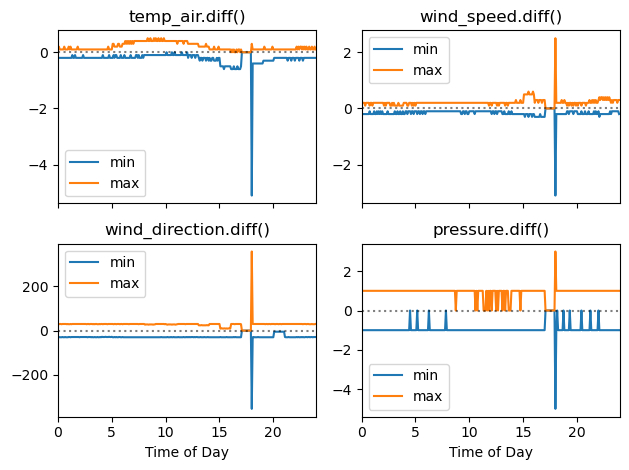

In [6]:
_ = make_difference_plot(df_5min)

In [7]:
df_15min, _ = pvlib.iotools.get_psm3(latitude=40, longitude=-100,
                                     names='2020', interval=15,
                                     api_key='DEMO_KEY', email='assessingsolar@gmail.com',
                                     map_variables=True, leap_day=True)

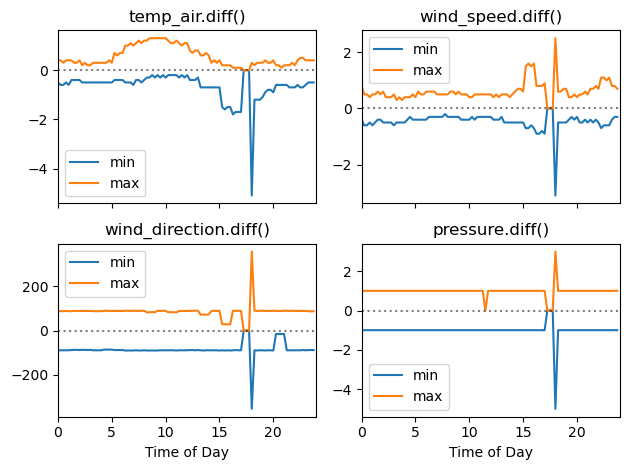

In [8]:
_ = make_difference_plot(df_15min)

In [9]:
df_30min, _ = pvlib.iotools.get_psm3(latitude=40, longitude=-100,
                                     names='2020', interval=30,
                                     api_key='DEMO_KEY', email='assessingsolar@gmail.com',
                                     map_variables=True, leap_day=True)

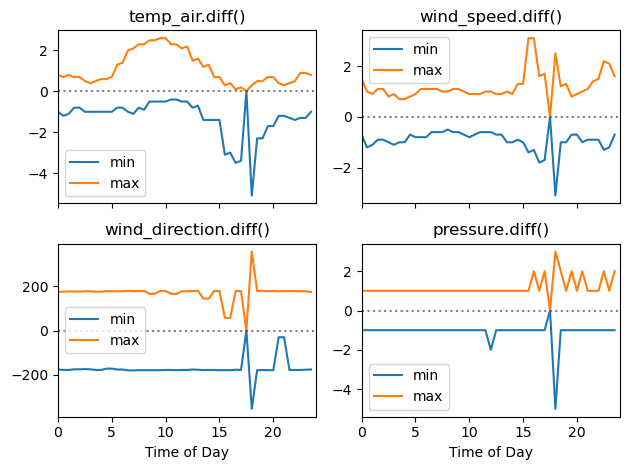

In [10]:
_ = make_difference_plot(df_30min)

It is worth noting that the three irradiance fields don't seem to suffer from this artifact:

Text(0.5, 0, 'Local Standard Time')

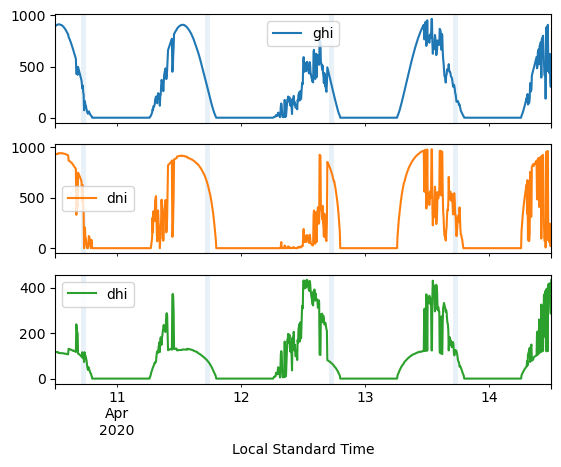

In [11]:
subset = df_5min.loc['2020-04-10 12:00':'2020-04-14 12:00']
axes = subset[['ghi', 'dni', 'dhi']].plot(subplots=True)

# highlight the 23:00 UTC hour each day
for dt in np.unique(subset.index.floor('d')):
    st = dt + pd.Timedelta(hours=23) + offset
    ed = st + pd.Timedelta(minutes=60)
    for ax in axes:
        ax.axvspan(st, ed, alpha=0.1)

ax.set_xlabel('Local Standard Time')

In [12]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2023-01-23 21:00:14

numpy     : 1.22.3
pvlib     : 0.9.3
matplotlib: 3.5.2
pandas    : 1.5.0

